# Classifying Point Clouds with PointNet

We are going to build deep learning architectures to classify point clouds that were extracted from self-driving car LiDAR scans.

* Construct the basic pipeline used for point cloud classification
* Analyze the results from our model and look for potential points of improvement
* Understand the limitations of the model and improve it using positional encodings

## Setup

In [1]:
import sys
sys.path.insert(0, 'src')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from vision.utils import verify

In [3]:
device = torch.device('cpu')
# If you have an NVIDIA GPU with at least 2 GB of VRAM, set this to True
use_cuda = False
# If you have an Apple Silicon Mac, set this to True
use_apple_silicon = True
if torch.cuda.is_available():
    if use_cuda:
        device = torch.device('cuda')
        print("CUDA-compatible NVIDIA GPU enabled.")
    else:
        print("CUDA-compatible NVIDIA GPU detected. Consider setting use_cuda to True.")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    if use_apple_silicon:
        device = torch.device('mps')
        print("Apple Silicon GPU enabled.")
    else:
        print("Apple Silicon GPU detected. Consider setting use_apple_silicon to True.")
        

print("Using device: %s" % str(device))

Apple Silicon GPU enabled.
Using device: mps


Lets take a second to visualize a few point clouds that we are going to train our model on. You might need to rotate the visualization before you can actually see the object being represented by the points.

In [4]:
from vision.utils import plot_cloud_from_file

plot_cloud_from_file('data/sweeps/PEDESTRIAN/11.txt')

## Part 1: Data Loading

The first order of business we're going to take care of is writing a PyTorch dataset that will load in the data we'll be using to train and test our model. We have a total of 20 different classes that all found under the `data/sweeps` folder and each class has been split into a training and testing set. We will write a class that will load the appropriate data given the split we pass in (i.e. train/test split).


In [ ]:
from vision.part1_dataloader import Argoverse
from torch.utils.data import DataLoader

Now we can load in our data. When extracting object point clouds from LiDAR scans, we pruned point clouds with large numbers of points to reduce the computational demand of training and testing our classifiers. We pruned all point clouds to have a maximum of 200 points so that is the size that we will be padding all of the other point clouds to. 

In [7]:
train_dataset = Argoverse('train', 'data/sweeps', 200)
test_dataset = Argoverse('test', 'data/sweeps', 200)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Part 2: Baseline

A very simple baseline to start with is a voxel-based approach. Our overall point cloud falls in a 4x4x4 meter volume in space. We can divide this up into 1x1x1 meter volumes which would give us a total of 64 $1m^3$ cells. We build a 64-dimensional feature for a point by simply counting how many points in the point cloud fall into each cell then normalizng the resulting feature vector.

Lets train our baseline implementation and see how it does! 

In [10]:
lr = 0.05
weight_decay = 1e-4
epochs = 10

model = Baseline(20, voxel_resolution=8, mode="occupancy")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [11]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader)

Epoch 1

Training...


100%|██████████| 213/213 [00:00<00:00, 287.33it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 288.04it/s]
/Users/poorvaja/Documents/GT/CV/project-5-student/src/vision/training.py:94: UserWarning:

Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1762088872837/work/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)




Epoch 1 Stats:
	Training accuracy: 0.6438
	Training loss: 1.3509
	Validation accuracy: 0.4500
	Validation loss: 2.9525

Validation accuracy improved from 0 to 0.44999998807907104
Saving model to Baseline.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:00<00:00, 668.11it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 713.51it/s]



Epoch 2 Stats:
	Training accuracy: 0.7629
	Training loss: 0.8269
	Validation accuracy: 0.4150
	Validation loss: 2.7183


Epoch 3

Training...


100%|██████████| 213/213 [00:00<00:00, 666.65it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 728.43it/s]



Epoch 3 Stats:
	Training accuracy: 0.7915
	Training loss: 0.6959
	Validation accuracy: 0.4483
	Validation loss: 3.3468


Epoch 4

Training...


100%|██████████| 213/213 [00:00<00:00, 642.72it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 689.17it/s]



Epoch 4 Stats:
	Training accuracy: 0.8021
	Training loss: 0.6578
	Validation accuracy: 0.5100
	Validation loss: 3.0110

Validation accuracy improved from 0.44999998807907104 to 0.5099999904632568
Saving model to Baseline.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:00<00:00, 620.70it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 482.08it/s]



Epoch 5 Stats:
	Training accuracy: 0.8235
	Training loss: 0.5913
	Validation accuracy: 0.4550
	Validation loss: 3.2148


Epoch 6

Training...


100%|██████████| 213/213 [00:00<00:00, 638.29it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 695.64it/s]



Epoch 6 Stats:
	Training accuracy: 0.8079
	Training loss: 0.6172
	Validation accuracy: 0.4733
	Validation loss: 3.1452


Epoch 7

Training...


100%|██████████| 213/213 [00:00<00:00, 639.74it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 704.78it/s]



Epoch 7 Stats:
	Training accuracy: 0.8097
	Training loss: 0.6085
	Validation accuracy: 0.4850
	Validation loss: 3.4049


Epoch 8

Training...


100%|██████████| 213/213 [00:00<00:00, 636.54it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 708.78it/s]



Epoch 8 Stats:
	Training accuracy: 0.8315
	Training loss: 0.5345
	Validation accuracy: 0.4900
	Validation loss: 3.3573


Epoch 9

Training...


100%|██████████| 213/213 [00:00<00:00, 620.88it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 727.19it/s]



Epoch 9 Stats:
	Training accuracy: 0.8326
	Training loss: 0.5562
	Validation accuracy: 0.4983
	Validation loss: 2.9219


Epoch 10

Training...


100%|██████████| 213/213 [00:00<00:00, 641.44it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 719.71it/s]


Epoch 10 Stats:
	Training accuracy: 0.8247
	Training loss: 0.5442
	Validation accuracy: 0.4733
	Validation loss: 3.6392




In [12]:
model = torch.load('output/Baseline.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████| 38/38 [00:00<00:00, 613.82it/s]

Test accuracy: 0.5100
Test loss: 3.0772


## Part 3: PointNet

Now that we have a baseline to compare to, we're going to build a simplified version of PointNet which was first published in 2017 by researchers at Stanford University. You can view the original website for this publication [here](https://stanford.edu/~rqi/pointnet/). 

We will be slightly modifying the original architecture. The architecture described in the PointNet publication includes two modules that we will not be implementing. Namely, they are the input transform and the feature transform.


In [ ]:
from vision.part3_pointnet import PointNet

Now that we have a PointNet implementation, lets train our model and see how it does. 

In [24]:
lr = 0.001
weight_decay = 1e-4
epochs = 20

model = PointNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [25]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:01<00:00, 122.86it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 201.37it/s]



Epoch 1 Stats:
	Training accuracy: 0.2650
	Training loss: 2.1732
	Validation accuracy: 0.4000
	Validation loss: 1.9316

Validation accuracy improved from 0 to 0.4000000059604645
Saving model to PointNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:01<00:00, 167.74it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 396.75it/s]



Epoch 2 Stats:
	Training accuracy: 0.4629
	Training loss: 1.5671
	Validation accuracy: 0.4567
	Validation loss: 1.6283

Validation accuracy improved from 0.4000000059604645 to 0.4566666781902313
Saving model to PointNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:01<00:00, 172.27it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 395.93it/s]



Epoch 3 Stats:
	Training accuracy: 0.5462
	Training loss: 1.3564
	Validation accuracy: 0.3900
	Validation loss: 1.6640


Epoch 4

Training...


100%|██████████| 213/213 [00:01<00:00, 162.31it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 414.16it/s]



Epoch 4 Stats:
	Training accuracy: 0.6197
	Training loss: 1.1536
	Validation accuracy: 0.4683
	Validation loss: 1.5014

Validation accuracy improved from 0.4566666781902313 to 0.46833333373069763
Saving model to PointNet.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:01<00:00, 178.30it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 412.60it/s]



Epoch 5 Stats:
	Training accuracy: 0.6397
	Training loss: 1.0714
	Validation accuracy: 0.5433
	Validation loss: 1.6964

Validation accuracy improved from 0.46833333373069763 to 0.5433333516120911
Saving model to PointNet.pt


Epoch 6

Training...


100%|██████████| 213/213 [00:01<00:00, 184.16it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 415.97it/s]



Epoch 6 Stats:
	Training accuracy: 0.6656
	Training loss: 1.0067
	Validation accuracy: 0.5167
	Validation loss: 1.6149


Epoch 7

Training...


100%|██████████| 213/213 [00:01<00:00, 182.29it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 333.08it/s]



Epoch 7 Stats:
	Training accuracy: 0.6803
	Training loss: 0.9564
	Validation accuracy: 0.5467
	Validation loss: 1.3378

Validation accuracy improved from 0.5433333516120911 to 0.54666668176651
Saving model to PointNet.pt


Epoch 8

Training...


100%|██████████| 213/213 [00:01<00:00, 180.86it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 412.99it/s]



Epoch 8 Stats:
	Training accuracy: 0.7171
	Training loss: 0.8555
	Validation accuracy: 0.5850
	Validation loss: 1.3247

Validation accuracy improved from 0.54666668176651 to 0.5849999785423279
Saving model to PointNet.pt


Epoch 9

Training...


100%|██████████| 213/213 [00:01<00:00, 181.35it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 406.05it/s]



Epoch 9 Stats:
	Training accuracy: 0.7259
	Training loss: 0.8532
	Validation accuracy: 0.5783
	Validation loss: 1.3909


Epoch 10

Training...


100%|██████████| 213/213 [00:01<00:00, 177.22it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 334.51it/s]



Epoch 10 Stats:
	Training accuracy: 0.7385
	Training loss: 0.7876
	Validation accuracy: 0.5083
	Validation loss: 1.5122


Epoch 11

Training...


100%|██████████| 213/213 [00:01<00:00, 175.93it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 402.73it/s]



Epoch 11 Stats:
	Training accuracy: 0.7276
	Training loss: 0.8444
	Validation accuracy: 0.6183
	Validation loss: 1.2105

Validation accuracy improved from 0.5849999785423279 to 0.6183333396911621
Saving model to PointNet.pt


Epoch 12

Training...


100%|██████████| 213/213 [00:01<00:00, 178.04it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 410.68it/s]



Epoch 12 Stats:
	Training accuracy: 0.7732
	Training loss: 0.6991
	Validation accuracy: 0.6017
	Validation loss: 1.2583


Epoch 13

Training...


100%|██████████| 213/213 [00:01<00:00, 176.75it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 335.08it/s]



Epoch 13 Stats:
	Training accuracy: 0.7771
	Training loss: 0.6728
	Validation accuracy: 0.6100
	Validation loss: 1.1830


Epoch 14

Training...


100%|██████████| 213/213 [00:01<00:00, 179.96it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 410.63it/s]



Epoch 14 Stats:
	Training accuracy: 0.7774
	Training loss: 0.6750
	Validation accuracy: 0.5767
	Validation loss: 1.3306


Epoch 15

Training...


100%|██████████| 213/213 [00:01<00:00, 181.25it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 408.91it/s]



Epoch 15 Stats:
	Training accuracy: 0.7741
	Training loss: 0.6642
	Validation accuracy: 0.5767
	Validation loss: 1.3040


Epoch 16

Training...


100%|██████████| 213/213 [00:01<00:00, 178.04it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 334.32it/s]



Epoch 16 Stats:
	Training accuracy: 0.7844
	Training loss: 0.6218
	Validation accuracy: 0.5983
	Validation loss: 1.3160


Epoch 17

Training...


100%|██████████| 213/213 [00:01<00:00, 177.95it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 412.46it/s]



Epoch 17 Stats:
	Training accuracy: 0.7979
	Training loss: 0.6108
	Validation accuracy: 0.5467
	Validation loss: 1.2316


Epoch 18

Training...


100%|██████████| 213/213 [00:01<00:00, 177.87it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 406.08it/s]



Epoch 18 Stats:
	Training accuracy: 0.8050
	Training loss: 0.5976
	Validation accuracy: 0.6183
	Validation loss: 1.2583


Epoch 19

Training...


100%|██████████| 213/213 [00:01<00:00, 181.99it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 319.87it/s]



Epoch 19 Stats:
	Training accuracy: 0.8041
	Training loss: 0.5826
	Validation accuracy: 0.5950
	Validation loss: 1.2604


Epoch 20

Training...


100%|██████████| 213/213 [00:01<00:00, 174.67it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 408.83it/s]



Epoch 20 Stats:
	Training accuracy: 0.8200
	Training loss: 0.5401
	Validation accuracy: 0.5933
	Validation loss: 1.4327




In [26]:
model = torch.load('output/PointNet.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████| 38/38 [00:00<00:00, 131.57it/s]

Test accuracy: 0.6183
Test loss: 1.1980


## Part 4: Performance Analysis

Now that we have a trained PointNet model, we can look at how it performs and what its shortcomings are. We are also going to analyze our point clouds to see which parts of them the model deemed to be most important in making its classification decision.

In [1]:
from vision.utils import (
    generate_and_plot_confusion_matrix,
    plot_crit_points_from_file
)

Lets use the confusion matrix to look at which mistakes our model is making most often.

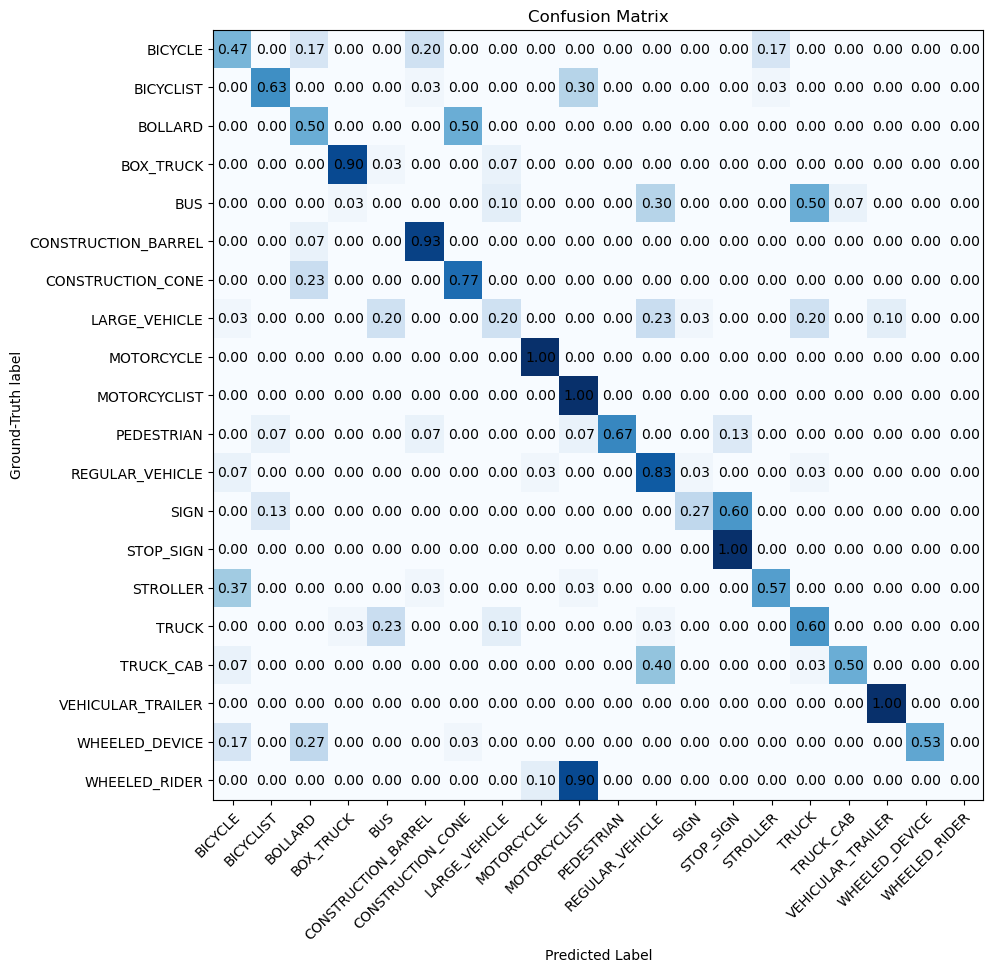

In [30]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

In [34]:
# plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)
plot_crit_points_from_file(model, 'data/sweeps/TRUCK_CAB/1.txt', 200)

## Part 5: T-Net

In [ ]:
from vision.part5_tnet import PointNetTNet

Let's check out how our model performs now that we added a T-Net.

In [41]:
lr = 0.001
weight_decay = 1e-4
epochs = 25

model = PointNetTNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [42]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:02<00:00, 88.36it/s] 



Testing...


100%|██████████| 38/38 [00:00<00:00, 196.10it/s]



Epoch 1 Stats:
	Training accuracy: 0.1879
	Training loss: 2.3234
	Validation accuracy: 0.3017
	Validation loss: 1.9198

Validation accuracy improved from 0 to 0.3016666769981384
Saving model to PointNetTNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:02<00:00, 105.24it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 274.03it/s]



Epoch 2 Stats:
	Training accuracy: 0.3638
	Training loss: 1.8408
	Validation accuracy: 0.4200
	Validation loss: 1.6713

Validation accuracy improved from 0.3016666769981384 to 0.41999998688697815
Saving model to PointNetTNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:01<00:00, 107.65it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 315.20it/s]



Epoch 3 Stats:
	Training accuracy: 0.4865
	Training loss: 1.4862
	Validation accuracy: 0.4467
	Validation loss: 1.4959

Validation accuracy improved from 0.41999998688697815 to 0.4466666579246521
Saving model to PointNetTNet.pt


Epoch 4

Training...


100%|██████████| 213/213 [00:01<00:00, 111.12it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 261.50it/s]



Epoch 4 Stats:
	Training accuracy: 0.5453
	Training loss: 1.3439
	Validation accuracy: 0.4483
	Validation loss: 1.6502

Validation accuracy improved from 0.4466666579246521 to 0.4483333230018616
Saving model to PointNetTNet.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:01<00:00, 110.87it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 311.71it/s]



Epoch 5 Stats:
	Training accuracy: 0.5965
	Training loss: 1.2297
	Validation accuracy: 0.5067
	Validation loss: 1.4553

Validation accuracy improved from 0.4483333230018616 to 0.5066666603088379
Saving model to PointNetTNet.pt


Epoch 6

Training...


100%|██████████| 213/213 [00:01<00:00, 106.97it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 295.52it/s]



Epoch 6 Stats:
	Training accuracy: 0.6365
	Training loss: 1.0763
	Validation accuracy: 0.4867
	Validation loss: 1.4960


Epoch 7

Training...


100%|██████████| 213/213 [00:02<00:00, 103.19it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 271.97it/s]



Epoch 7 Stats:
	Training accuracy: 0.6368
	Training loss: 1.0707
	Validation accuracy: 0.5133
	Validation loss: 1.3722

Validation accuracy improved from 0.5066666603088379 to 0.5133333206176758
Saving model to PointNetTNet.pt


Epoch 8

Training...


100%|██████████| 213/213 [00:02<00:00, 104.73it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 310.20it/s]



Epoch 8 Stats:
	Training accuracy: 0.6774
	Training loss: 0.9604
	Validation accuracy: 0.4933
	Validation loss: 1.5999


Epoch 9

Training...


100%|██████████| 213/213 [00:01<00:00, 108.85it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 305.37it/s]



Epoch 9 Stats:
	Training accuracy: 0.6885
	Training loss: 0.9286
	Validation accuracy: 0.5433
	Validation loss: 1.3248

Validation accuracy improved from 0.5133333206176758 to 0.5433333516120911
Saving model to PointNetTNet.pt


Epoch 10

Training...


100%|██████████| 213/213 [00:01<00:00, 107.27it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 270.90it/s]



Epoch 10 Stats:
	Training accuracy: 0.7144
	Training loss: 0.8799
	Validation accuracy: 0.5367
	Validation loss: 1.2020


Epoch 11

Training...


100%|██████████| 213/213 [00:02<00:00, 102.79it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 295.49it/s]



Epoch 11 Stats:
	Training accuracy: 0.7385
	Training loss: 0.8102
	Validation accuracy: 0.5383
	Validation loss: 1.3564


Epoch 12

Training...


100%|██████████| 213/213 [00:01<00:00, 110.72it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 327.51it/s]



Epoch 12 Stats:
	Training accuracy: 0.7262
	Training loss: 0.8157
	Validation accuracy: 0.5483
	Validation loss: 1.2512

Validation accuracy improved from 0.5433333516120911 to 0.5483333468437195
Saving model to PointNetTNet.pt


Epoch 13

Training...


100%|██████████| 213/213 [00:02<00:00, 104.87it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 311.01it/s]



Epoch 13 Stats:
	Training accuracy: 0.7335
	Training loss: 0.7841
	Validation accuracy: 0.6350
	Validation loss: 1.1806

Validation accuracy improved from 0.5483333468437195 to 0.6349999904632568
Saving model to PointNetTNet.pt


Epoch 14

Training...


100%|██████████| 213/213 [00:01<00:00, 108.45it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 259.02it/s]



Epoch 14 Stats:
	Training accuracy: 0.7465
	Training loss: 0.7374
	Validation accuracy: 0.4967
	Validation loss: 1.5701


Epoch 15

Training...


100%|██████████| 213/213 [00:02<00:00, 104.29it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 310.79it/s]



Epoch 15 Stats:
	Training accuracy: 0.7794
	Training loss: 0.6659
	Validation accuracy: 0.6267
	Validation loss: 1.1416


Epoch 16

Training...


100%|██████████| 213/213 [00:02<00:00, 106.24it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 323.44it/s]



Epoch 16 Stats:
	Training accuracy: 0.7703
	Training loss: 0.7182
	Validation accuracy: 0.5950
	Validation loss: 1.4443


Epoch 17

Training...


100%|██████████| 213/213 [00:01<00:00, 108.61it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 299.15it/s]



Epoch 17 Stats:
	Training accuracy: 0.7794
	Training loss: 0.6718
	Validation accuracy: 0.5867
	Validation loss: 1.2394


Epoch 18

Training...


100%|██████████| 213/213 [00:01<00:00, 109.91it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 323.75it/s]



Epoch 18 Stats:
	Training accuracy: 0.7744
	Training loss: 0.7084
	Validation accuracy: 0.5383
	Validation loss: 1.3787


Epoch 19

Training...


100%|██████████| 213/213 [00:01<00:00, 107.16it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 303.29it/s]



Epoch 19 Stats:
	Training accuracy: 0.7926
	Training loss: 0.6440
	Validation accuracy: 0.5517
	Validation loss: 1.2120


Epoch 20

Training...


100%|██████████| 213/213 [00:01<00:00, 109.56it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 308.02it/s]



Epoch 20 Stats:
	Training accuracy: 0.8009
	Training loss: 0.6311
	Validation accuracy: 0.6183
	Validation loss: 1.3075


Epoch 21

Training...


100%|██████████| 213/213 [00:01<00:00, 108.07it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 309.92it/s]



Epoch 21 Stats:
	Training accuracy: 0.8065
	Training loss: 0.6047
	Validation accuracy: 0.5700
	Validation loss: 1.4864


Epoch 22

Training...


100%|██████████| 213/213 [00:01<00:00, 108.67it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 293.76it/s]



Epoch 22 Stats:
	Training accuracy: 0.7974
	Training loss: 0.6154
	Validation accuracy: 0.6083
	Validation loss: 1.4329


Epoch 23

Training...


100%|██████████| 213/213 [00:02<00:00, 106.39it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 253.05it/s]



Epoch 23 Stats:
	Training accuracy: 0.8065
	Training loss: 0.6015
	Validation accuracy: 0.5733
	Validation loss: 1.4223


Epoch 24

Training...


100%|██████████| 213/213 [00:01<00:00, 107.02it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 292.42it/s]



Epoch 24 Stats:
	Training accuracy: 0.8294
	Training loss: 0.5411
	Validation accuracy: 0.6000
	Validation loss: 1.4608


Epoch 25

Training...


100%|██████████| 213/213 [00:01<00:00, 107.59it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 295.85it/s]



Epoch 25 Stats:
	Training accuracy: 0.8062
	Training loss: 0.6111
	Validation accuracy: 0.5983
	Validation loss: 1.4121




In [43]:
model = torch.load('output/PointNetTNet.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████| 38/38 [00:00<00:00, 74.40it/s]

Test accuracy: 0.6350
Test loss: 1.1834


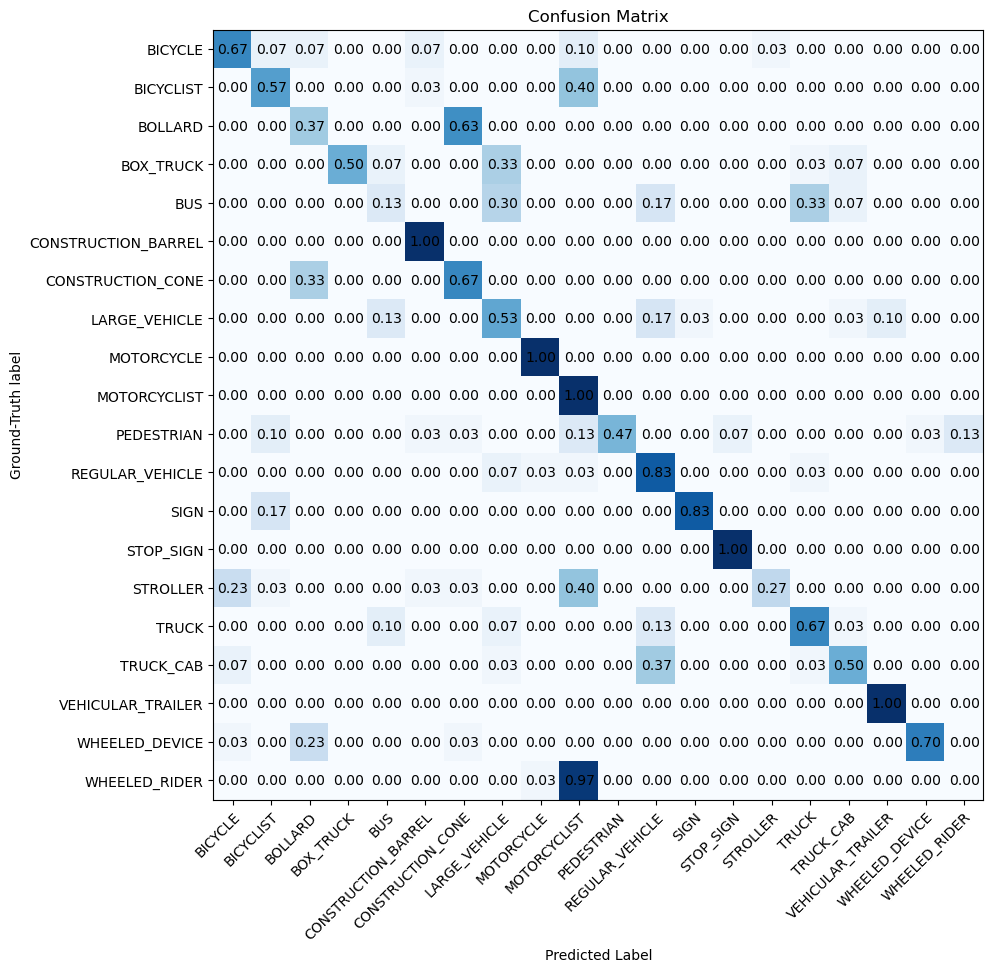

In [44]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

In [ ]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)